# Mintervention Aware Optimization

This notebook demonstrates Python algorithms for optimal control constrained by keepout sets. We compare barrier methods to the new Mintervention-aware optimization

In [35]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mplt
import numpy.linalg as LA
%matplotlib inline

# David McPherson's personal colors for plotting:
# Rows sorted by LAB L-value : 50, 20, 70
# Columns sorted by color : Rust, Turquoise, Sand, Indigo, Teal, Spring, Flesh, Magenta, Gray
colors = [['#cf4c34','#078752','#6333ed','#d6ca54','#0ca0ad','#2ea62a','#c96b0d','#d947bb','#777777'],
          ['#4C1C13','#073824','#2E186E','#575122','#065057','#164F14','#000000','#000000','#4D4D4D'],
          ['#FF745A','#0BD480','#9A7DF0','#FFF59C','#EEEEEE','#EEEEEE','#EEEEEE','#EEEEEE','#ABABAB']]

plt.rcParams['font.sans-serif'] = "Gill Sans"
plt.rcParams['font.serif'] = "Georgia"
plt.rcParams['font.family'] = "Georgia"
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 100

In [36]:
# Import custom libraries
import dlqr
import dynamics as dyn

In [37]:
# Simplify plots
def muteAxes(ax,xrange,yrange):
    # Remove axis lines.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Set ticks
    ax.xaxis.set_ticks(xrange)
    ax.yaxis.set_ticks(yrange)

    ax.tick_params(direction='in')
    for xb in xrange:
        for yb in yrange:
            rect = mplt.patches.Rectangle((xb+0.05,yb+0.05),0.9,0.9,color='#EEEEEE')
            ax.add_patch(rect)
    ax.xaxis.label.set_color('#777777')
    ax.tick_params(axis='x', colors='#777777')
    ax.yaxis.label.set_color('#777777')
    ax.tick_params(axis='y', colors='#777777')

# Define the Dynamics to be used
The dynamics functions are accessed through an extension of the dynamics abstract base class (DynamicsABC) that provides handles to the flow and its (partial) derivatives.

In [38]:
# Double integrator dynamics
class TelescopingInvertedPendulum(dyn.DynamicsABC):

    """
    Encodes double integrator dynamics

    Operates on a two-dimensional state space (z) with numbered states encoding:

      1. Angular position (w)
      2. Angular velocity (v)
      1. Leg length (l)
      2. Length velocity (r)

    with the form:

    dw/dt = v
    dv/dt = u_0 + sin(w) / l
    dl/dt = r
    dr/dt = u_1
    """

    def f(self,state,control):
        """Dynamic drift function of state over time

        Args:
            state (np.array): state at which to evaluate the dynamics
            control (np.array): exogenous (control) input at which to evaluate the dynamics

        Returns:
            derivative (np.array): the time derivative of state over time according to these dynamics
        """
        Az = np.array([
                       state[1],
                       np.sin(state[0]) / state[2],
                       state[3],
                       0
                      ])
        Bu = np.array([
                       0,
                       control[0],
                       0,
                       control[1]
                      ])
        derivative = Az + Bu
        return(derivative)

    def deriv_x(self,state,control):
        """Derivative of dynamics with respect to state

        Args:
            state (np.array): state at which to evaluate the dynamics
            control (np.array): exogenous (control) input at which to evaluate the dynamics

        Returns:
            A (np.array): partial derivative of dynamics with respect to state
        """
        A = np.zeros((4,4))
        A[0,1] = 1
        A[1,0] = np.cos(state[0]) / state[2]
        A[1,2] = -np.sin(state[0]) / (state[2]*state[2])
        A[2,3] = 1
        return(A)

    def deriv_u(self,state,control):
        """Derivative of dynamics with respect to control

        Args:
            state (np.array): state at which to evaluate the dynamics
            control (np.array): exogenous (control) input at which to evaluate the dynamics

        Returns:
            B (np.array): partial derivative of dynamics with respect to state
        """
        B = np.array([
                      [0,0],
                      [1,0],
                      [0,0],
                      [0,1],
                     ])
        return(B)

    def __init__(self):
        super(TelescopingInvertedPendulum,self).__init__(4,2)

In [39]:
vehicle = TelescopingInvertedPendulum()
timestep_length = 0.01

## Load the Barriers and test them

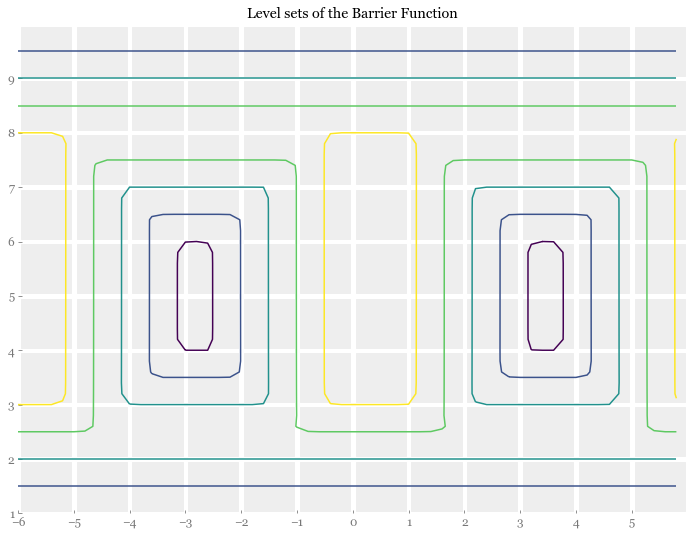

In [40]:
# Load the Safe Sets
import level_sets
#safeLevel = level_sets.GriddedLevelSetFunction("reachsets/invertedPendulum5TenthsStill_reachset.json")
#safeLevel = level_sets.GriddedLevelSetFunction("reachsets/invertedPendulum7Tenths_reachset.json")
safeLevel = level_sets.GriddedLevelSetFunction("reachsets/telescopingVInvertedPendulum5TenthsNoMidLength_LengthBounds_reachset.json")
#safeLevel = level_sets.GriddedLevelSetFunction("reachsets/invertedPendulum4Ninths_reachset.json")

# Setup the figure
fig = plt.figure(figsize=[12,9])
plt.axis([-6,6,1,10])
#plt.axis([1,10,-4,4])
ax = fig.axes[0]
muteAxes(ax,range(-6,6),range(1,10))
#muteAxes(ax,range(1,10),range(-4,4))

def setproj(ex,ey):
    return([ex,0,ey,0])
    #return([3.14,0,ex,ey])

# Plot the safe set
delta = 0.2
x = np.arange(-6.0, 6.0, delta)
y = np.arange(1.0, 10.0, delta)
#x = np.arange(1.0, 10.0, delta)
#y = np.arange(-4.0, 4.0, delta)
X, Y = np.meshgrid(x, y)
z = np.array([safeLevel.value(setproj(ex,ey)) for ex,ey in zip(X.flatten(),Y.flatten())])
Z = z.reshape(X.shape)
CS = plt.contour(X, Y, Z, [0,0.5,1,1.5,2])

# Plot the gradient of the levels (the direction the controller will choose to go)
#u = np.array([safeLevel.gradient(setproj(ex,ey))[0] for ex,ey in zip(X.flatten(),Y.flatten())])
#U = u.reshape(X.shape)
#v = np.array([safeLevel.gradient(setproj(ex,ey))[1] for ex,ey in zip(X.flatten(),Y.flatten())])
#V = v.reshape(X.shape)
#plt.quiver(X,Y, U,V)

plt.title('Level sets of the Barrier Function')
plt.show()

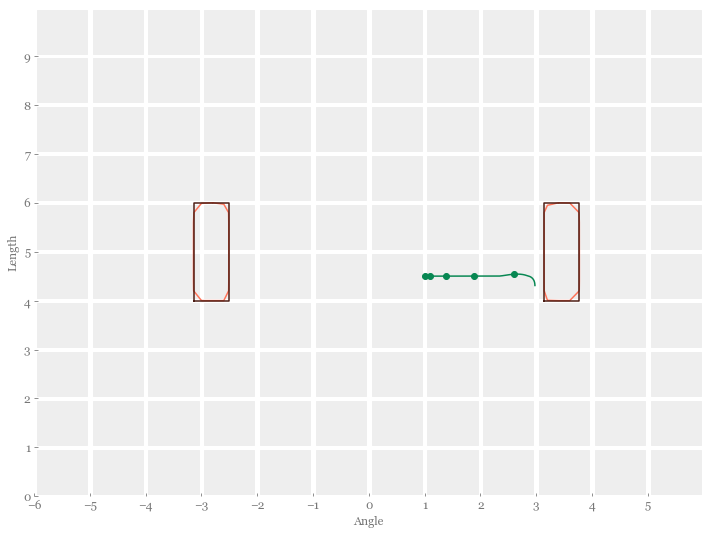

In [52]:
# Setup the figure
fig = plt.figure(figsize=[12,9])
plt.axis([-6,6,0,10])
ax = fig.axes[0]
muteAxes(ax,range(-6,6),range(0,10))

# Test the safe set with controls that drive straight into the obstacle
vehicle = TelescopingInvertedPendulum()
safe_vehicle = dyn.MinimumInterventionDynamicsWrapper(vehicle,safeLevel)
timestep_length = 0.01

# Forward simulate the dynamics with zero control
N = 500
states_init = np.zeros((safe_vehicle.dimZ,N+1))
control_init = np.zeros((safe_vehicle.dimU,N))
states_init[:,0] = np.array([1,0,4.5,0])
for i in np.arange(0,N):
    control_init[:,i] = np.zeros((safe_vehicle.dimU,))
    states_init[:,i+1] = states_init[:,i] + timestep_length * safe_vehicle.f(states_init[:,i],control_init[:,i])

# Plot the safe set intervention behavior on a mindless controller
CS = plt.contour(X, Y, Z, [0], colors = [colors[2][0]])
plt.xlabel("Angle")
plt.ylabel("Length")

plt.plot(states_init[0,:],states_init[2,:],color=colors[0][1])
plt.plot(states_init[0,np.arange(0,N,100)],states_init[2,np.arange(0,N,100)],'ro',color=colors[0][1])

obsAngTick = 5
angle1 = ( obsAngTick   /10)*2*np.pi
angle2 = ((obsAngTick+1)/10)*2*np.pi
ys = np.array([4,4,6,6,4])
#ys = ys * 0.12
plt.plot(np.array([angle1,angle2,angle2,angle1,angle1]),
         ys,
         color=colors[1][0])
plt.plot(np.array([angle1-2*np.pi,angle2-2*np.pi,angle2-2*np.pi,angle1-2*np.pi,angle1-2*np.pi]),
         ys,
         color=colors[1][0])

In [53]:
safe_vehicle = dyn.MinimumInterventionDynamicsWrapper(vehicle,safeLevel)

## Set the Agent's goals

In [54]:
# Define the Agent's objective function
import objective_functions as of
import quadratic_objectives as qof
import avoidance_objective as caof

In [55]:
# Define the custom angle-wrapping objective
class WrappedFirstState(of.RunningCostABC):
    """
    Wraps around a cost function but pre-processes its state to wrap the value in the interval
    [wraplowend, wraplowend+wraplength]
    Assumes 
    """
    def __init__(self,cost0,wraplength,wraplowend):
        self.cost0 = cost0
        self.wraplength = wraplength
        self.wraplowend = wraplowend
        super(WrappedFirstState,self).__init__()
        
    def wrap(self,state):
        wrapped_state = np.copy(state)
        wrapped_state[0] = (state[0] - self.wraplowend) % self.wraplength + self.wraplowend
        return(wrapped_state)

    def f(self,state,control,timestep):
        """Running cost for optimal control problem

        Args:
            state (np.array): state at which to evaluate the cost function
            control (np.array): exogenous (control) input at which to evaluate the cost function
            timestep (int): current timestep (for time-varying costs)
        """
        return(self.cost0.f(self.wrap(state),control,timestep) )

    def deriv_statestate(self,state,control,timestep):
        """Second derivative of running cost with respect to state

        Args:
            state (np.array): state at which to evaluate the cost function
            control (np.array): exogenous (control) input at which to evaluate the cost function
            timestep (int): current timestep (for time-varying costs)

        Returns:
            Hessian (np.matrix): second derivative with dimension z by z, where z is the dimension of the state
                vector

        This method is used to produce a second-order Taylor approximation of the cost around a guess trajectory.
        """
        return(self.cost0.deriv_statestate(self.wrap(state),control,timestep))

    def deriv_state(self,state,control,timestep):
        """First derivative of running cost with respect to state

        Args:
            state (np.array): state at which to evaluate the cost function
            control (np.array): exogenous (control) input at which to evaluate the cost function
            timestep (int): current timestep (for time-varying costs)
        """
        return(self.cost0.deriv_state(self.wrap(state),control,timestep))

    def deriv_controlcontrol(self,state,control,timestep):
        """Second derivative of running cost with respect to exogenous (control) input

        Args:
            state (np.array): state at which to evaluate the cost function
            control (np.array): exogenous (control) input at which to evaluate the cost function
            timestep (int): current timestep (for time-varying costs)

        Returns:
            Hessian (np.matrix): second derivative with dimension z by z, where z is the dimension of the control
                vector

        This method is used to produce a second-order Taylor approximation of the cost around a guess trajectory.

        """
        return(self.cost0.deriv_controlcontrol(self.wrap(state),control,timestep))

    def deriv_control(self,state,control,timestep):
        """First derivative of running cost with respect to exogenous (control) input

        Args:
            state (np.array): state at which to evaluate the cost function
            control (np.array): exogenous (control) input at which to evaluate the cost function
            timestep (int): current timestep (for time-varying costs)
        """
        return(self.cost0.deriv_control(self.wrap(state),control,timestep))


In [70]:
runningControlCost = qof.QuadraticControlCost(dlqr.QuadraticForm(vehicle.dimU,np.diag([0.05,0.05]),np.zeros((vehicle.dimU,1)),0))

Qprox = np.diag([1,0,1,0])
goal_state = np.array([0.7*2*np.pi,0,5,0])
terminalCost = of.TerminalCost(
    WrappedFirstState(
    qof.QuadraticStateCost(
        dlqr.QuadraticForm(vehicle.dimZ,Qprox,
                           -2*Qprox*np.matrix(goal_state).T,
                           np.dot(np.dot(goal_state.transpose(),Qprox),goal_state) )
        )
    ,2*np.pi,-np.pi)
    * 80)

Agent_objective = runningControlCost*1

## Optimize trajectory with iLQR

In [78]:
import ilqr

startingState = np.array([1,0,4.5,0])
# Initialize a random control-trace
cost = 999999
while cost > 10000:
    # Forward simulate the dynamics with zero control
    startingState = np.copy(startingStates[ii])
    states_init[:,0] = startingState
    cost = 0
    #control_init[:,-1] = np.zeros((safe_vehicle.dimU,))
    constant_control = np.random.rand(safe_vehicle.dimU,)*2 - np.ones((safe_vehicle.dimU,))
    for i in np.arange(0,N):
        #control_init[:,i] = control_init[:,i-1] + timestep_length*(np.random.rand(safe_vehicle.dimU,)*2 - np.ones((safe_vehicle.dimU,)))
        control_init[:,i] = constant_control
        states_init[:,i+1] = states_init[:,i] + timestep_length * safe_vehicle.f(states_init[:,i],control_init[:,i])
        cost = cost + timestep_length*Agent_objective.f(states_init[:,i],control_init[:,i],i)
    cost = cost + terminalCost.f(states_init[:,N])
    print("Initial cost is ",cost)

mintervener_method_states, mintervener_method_controls = ilqr.iterative_LQR(states_init,control_init,
                                                                            timestep_length,
                                                                            safe_vehicle,
                                                                            Agent_objective,
                                                                            terminal_cost = terminalCost * (1/timestep_length),
                                                                            neverRetreat=True,ITER_NUM=11)

Initial cost is  [[6122.8751224]]
Initialization's cost is  6122.875122396591
1 753.1705505360336
2 400.25276512110986
3 250.98057588181723
4 214.00687378943195
5 214.00687378943195
6 214.00687378943195
7 214.00687378943195
8 214.00687378943195
9 214.00687378943195
10 214.00687378943195


<function matplotlib.pyplot.show(close=None, block=None)>

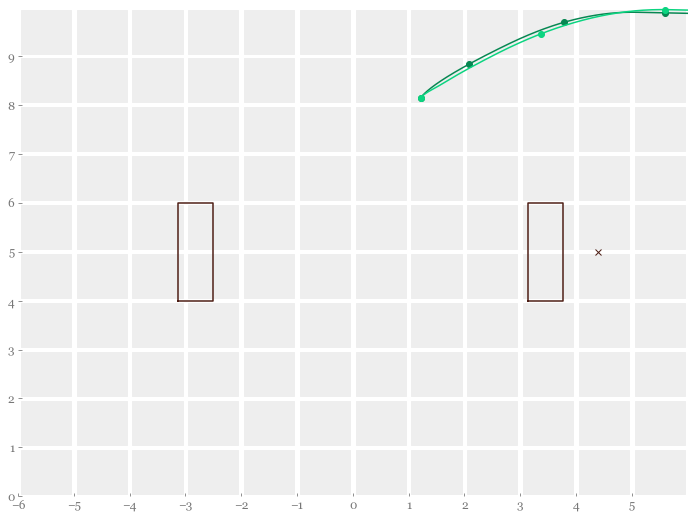

In [79]:
# Plot the resultant trajectories

# Setup the figure
fig = plt.figure(figsize=[12,9])
plt.axis([-6,6,0,10])
ax = fig.axes[0]
muteAxes(ax,range(-6,6),range(0,10))

dotTimes = np.arange(0,N,100)
# Plot the initialization
plt.plot(states_init[0,:],states_init[2,:],color=colors[0][1])
plt.plot(states_init[0,dotTimes],
         states_init[2,dotTimes],
         'ro',color=colors[0][1])

# Plot the iterative LQR optimized trajectory
plt.plot(mintervener_method_states[0,:],mintervener_method_states[2,:],color=colors[2][1])
plt.plot(mintervener_method_states[0,dotTimes],
         mintervener_method_states[2,dotTimes],
         'ro',color=colors[2][1])

# Plot the goal point
plt.plot(goal_state[0],goal_state[2],'x',color=colors[1][0])
# Plot the constraint
plt.plot(np.array([angle1,angle2,angle2,angle1,angle1]),
         ys,
         color=colors[1][0])
plt.plot(np.array([angle1-2*np.pi,angle2-2*np.pi,angle2-2*np.pi,angle1-2*np.pi,angle1-2*np.pi]),
         ys,
         color=colors[1][0])

plt.show

## Animate

<function matplotlib.pyplot.show(close=None, block=None)>

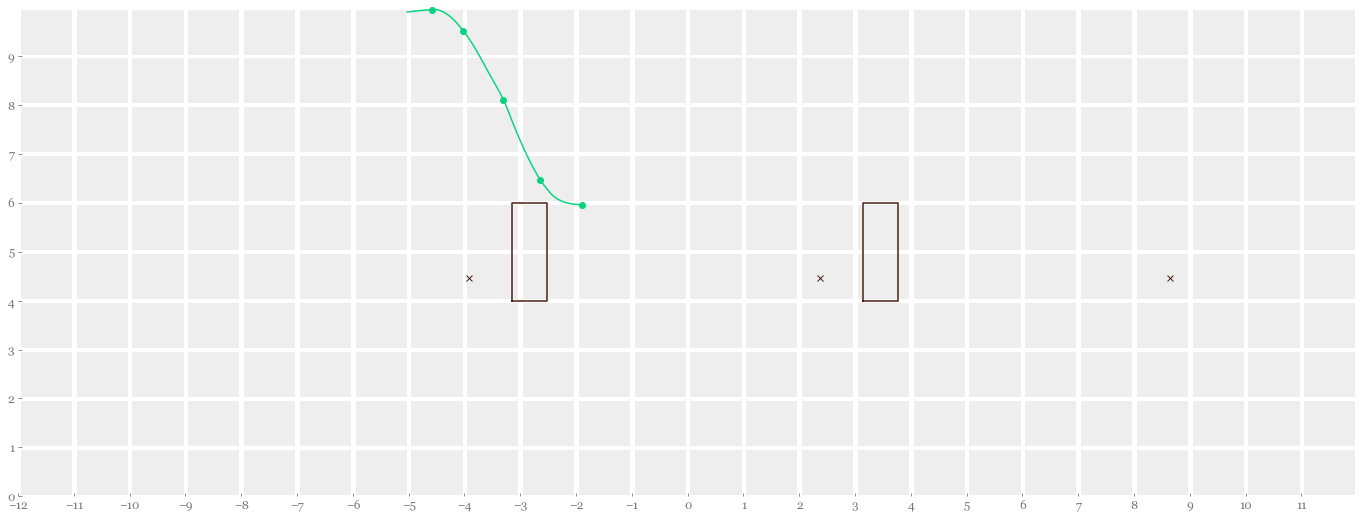

In [116]:
# Plot the resultant trajectories

# Setup the figure
fig = plt.figure(figsize=[24,9])
plt.axis([-12,12,0,10])
ax = fig.axes[0]
muteAxes(ax,range(-12,12),range(0,10))
dotTimes = np.arange(0,N,100)

trajID = 12
#trace = OptimizedTraces[trajID]
trace = optimized_states[trajID][1]

# Plot the iterative LQR optimized trajectory
plt.plot(trace[0,:],trace[2,:],color=colors[2][1])
plt.plot(trace[0,dotTimes],
         trace[2,dotTimes],
         'ro',color=colors[2][1])

# Plot the goal point
goal = endingGoals[trajID]
plt.plot(goal[0],goal[2],'x',color=colors[1][0])
plt.plot(goal[0]+2*np.pi,goal[2],'x',color=colors[1][0])
plt.plot(goal[0]-2*np.pi,goal[2],'x',color=colors[1][0])
# Plot the constraint
plt.plot(np.array([angle1,angle2,angle2,angle1,angle1]),
         ys,
         color=colors[1][0])
plt.plot(np.array([angle1-2*np.pi,angle2-2*np.pi,angle2-2*np.pi,angle1-2*np.pi,angle1-2*np.pi]),
         ys,
         color=colors[1][0])

plt.show

range(0, 10)

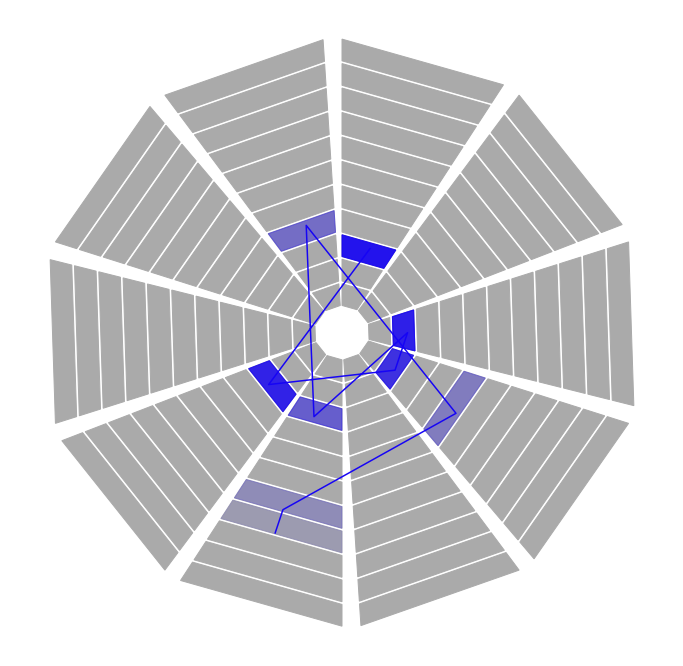

In [203]:
# Setup the figure
fig = plt.figure(figsize=[12,12])
plt.axis([-12,12,-12,12])
ax = fig.axes[0]
# Remove axis lines.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Set ticks
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.tick_params(direction='in')
# Set incremental tilings
angle_grid_spacing = 0.1
angth = angle_grid_spacing*2*np.pi * 0.9
for rb in [1,1.9,2.8,3.7,4.6,5.5,6.4,7.3,8.2,9.1,10]:
    for ab in np.arange(0,1,angle_grid_spacing)*2*np.pi:
        xy = np.array([[rb*np.sin(ab),(rb+0.8)*np.sin(ab),(rb+0.8)*np.sin(ab+angth),rb*np.sin(ab+angth),rb*np.sin(ab)],
                       [rb*np.cos(ab),(rb+0.8)*np.cos(ab),(rb+0.8)*np.cos(ab+angth),rb*np.cos(ab+angth),rb*np.cos(ab)]])
        poly = mplt.patches.Polygon(xy.transpose(),
                                   color = '#AAAAAA')
        ax.add_patch(poly)
        
angle = np.array([3.4558,3.4558,2.1991,5.9690,3.4558,1.5708,1.5708,2.1991,4.0841,0.3142])
length = np.array([7.7500,6.8500,5.0500,4.1500,3.2500,2.3500,2.3500,2.3500,3.2500,3.2500])
angle_coords = np.rint( angle /(angle_grid_spacing*2*np.pi) - 0.5)
lengt_coords = np.rint((length-1.45)/0.9)
mdpN = angle_coords.shape[0]
for ii in range(mdpN):
    rb = 1 + lengt_coords[ii]*0.9
    ab = 0 + angle_coords[ii]*angle_grid_spacing*2*np.pi
    xy = np.array([[rb*np.sin(ab),(rb+0.8)*np.sin(ab),(rb+0.8)*np.sin(ab+angth),rb*np.sin(ab+angth),rb*np.sin(ab)],
                   [rb*np.cos(ab),(rb+0.8)*np.cos(ab),(rb+0.8)*np.cos(ab+angth),rb*np.cos(ab+angth),rb*np.cos(ab)]])
    poly = mplt.patches.Polygon(xy.transpose(),
                               color = '#1604F5', alpha = (ii+1)/(mdpN+1))
    ax.add_patch(poly)
plt.plot(length*np.sin(angle),length*np.cos(angle),color = '#1604F5')


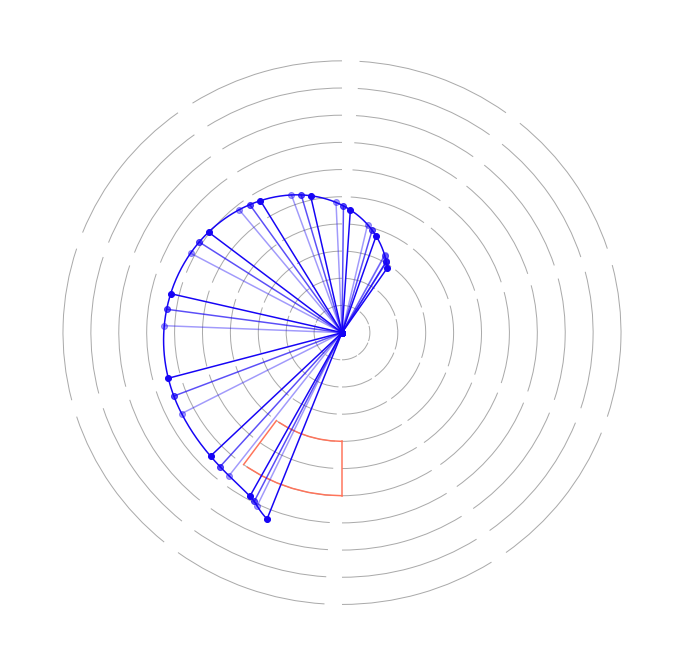

In [209]:
from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='html5')

# Setup the figure
fig = plt.figure(figsize=[12,12])
plt.axis([-12,12,-12,12])
ax = fig.axes[0]
# Remove axis lines.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Set ticks
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.tick_params(direction='in')
# Set incremental tilings
angle_grid_spacing = 0.1
for rb in [1,2,3,4,5,6,7,8,9,10]:
    for ab in np.arange(0,1,angle_grid_spacing):
        arc = mplt.patches.Arc((0,0),2*rb,2*rb,
                                color='#AAAAAA',
                                theta1 = 90+360*ab,
                                theta2 = 90+360*(ab+0.9*angle_grid_spacing))
        ax.add_patch(arc)
# Draw the obstacle
"""
ax.plot([4*np.sin(angle1),4*np.sin(angle2),6*np.sin(angle2),6*np.sin(angle1),4*np.sin(angle1)],
        [4*np.cos(angle1),4*np.cos(angle2),6*np.cos(angle2),6*np.cos(angle1),4*np.cos(angle1)],
        color=colors[2][0])
"""
ax.plot([6*np.sin(angle1),4*np.sin(angle1)],
        [6*np.cos(angle1),4*np.cos(angle1)],
        color=colors[2][0])
ax.plot(4*np.sin(angles1to2),
        4*np.cos(angles1to2),
        color=colors[2][0])
ax.plot([4*np.sin(angle2),6*np.sin(angle2)],
        [4*np.cos(angle2),6*np.cos(angle2)],
        color=colors[2][0])
ax.plot(6*np.sin(angles1to2),6*np.cos(angles1to2),
        color=colors[2][0])
#ax.xaxis.label.set_color('#777777')
#ax.tick_params(axis='x', colors='#777777')
#ax.yaxis.label.set_color('#777777')
#ax.tick_params(axis='y', colors='#777777')

lines = []
trajID = 0
trace = optimized_states[trajID][1]
for i in np.arange(0,501,50):
    """
    angle = trace[0,i]
    length = trace[2,i]
    x = [0,length * np.sin(angle)]
    y = [0,length * np.cos(angle)]
    line, = ax.plot(x,y , 'o-', color='#1604F5', alpha = (100+i)/600)
    lines.append(line)
    """
    for back in range(0,3):
        angle = trace[0,i-back*10]
        length = trace[2,i-back*10]
        x = [0,length * np.sin(angle)]
        y = [0,length * np.cos(angle)]
        line, = ax.plot(x,y , 'o-', color='#1604F5', alpha = 1 - back*0.3)
        lines.append(line)
    #"""

trace = trace = optimized_states[trajID][1]
angle = trace[0,:]
length = trace[2,:]
xes = length * np.sin(angle)
yes = length * np.cos(angle)
ax.plot(xes,yes, color='#1604F5')

In [125]:
# initialization function: plot the background of each frame
def init():
    for line in lines:
        line.set_data([], [])
    return (lines)

In [130]:
# animation function. This is called sequentially
length = 5
trajID = 0
def animate(i):
    """
    for ii in range(0,6):
        trace = OptimizedTraces[ii]
        angle = trace[0,i]
        speed = trace[1,i]
        x = [0,length * np.sin(angle)]
        y = [0,length * np.cos(angle)]
        lines[ii].set_data(x, y)
    """
    #trace = mintervener_method_states
    trace = trace = optimized_states[trajID][1]
    angle = trace[0,i]
    length = trace[2,i]
    x = [0,length * np.sin(angle)]
    y = [0,length * np.cos(angle)]
    lines[0].set_data(x,y)
    return (lines)

In [131]:
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig,
                               animate, init_func=init,
                               frames=500,
                               interval=10, blit=True)
anim

In [104]:
writervideo = animation.FFMpegWriter(fps=60) 
anim.save("export/telescopingPendulumAgent_NoMidLengthAtPi.mp4", writer=writervideo)

In [17]:
import csv
with open('export/pendulumAgent_NoObstacle.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(mintervener_method_states[0,:])
    writer.writerow(mintervener_method_states[1,:])

# Batch Production
Generate some variance with a fixed constraint set for regressing upon.

In [13]:
# Sample 100 uniformly distributed starting states and ending goals from the safe set

startingStates = [np.random.rand(4,) for ii in range(101)]
endingGoals = [np.random.rand(4,) for ii in range(101)]
for ii in range(101):
    startingSafety = -1
    endingSafety = -1
    while startingSafety < 0:
        startingStates[ii] = np.random.rand(4,)
        startingStates[ii][0] = startingStates[ii][0]*6.28 - 6.28*0.4
        startingStates[ii][1] = startingStates[ii][1]*4 - 2
        startingStates[ii][2] = startingStates[ii][2]*9 + 1
        startingStates[ii][3] = startingStates[ii][3]*4 - 2
        startingSafety = safeLevel.value(startingStates[ii])
    while endingSafety < 0:
        endingGoals[ii] = np.random.rand(4,)
        endingGoals[ii][0] = endingGoals[ii][0]*6.28 - 6.28*0.4
        endingGoals[ii][1] = endingGoals[ii][1]*4 - 2
        endingGoals[ii][2] = endingGoals[ii][2]*9 + 1
        endingGoals[ii][3] = endingGoals[ii][3]*4 - 2
        endingSafety = safeLevel.value(endingGoals[ii])

In [14]:
for ii in [1,4,9]:
    startingStates[ii] = np.random.rand(2,)
    endingGoals[ii] = np.random.rand(2,)
    startingStates[ii][0] = startingStates[ii][0]*6.28 - 6.28*0.4
    startingStates[ii][1] = startingStates[ii][1]*4 - 2
    endingGoals[ii][0] = endingGoals[ii][0]*6.28 - 6.28*0.4
    endingGoals[ii][1] = endingGoals[ii][1]*4 - 2
    print(startingStates[ii])
    print(endingGoals[ii])

[-0.44771279  0.69229116]
[-0.98332469 -1.36112741]
[-1.90418002 -0.81276183]
[ 3.14519125 -1.38501189]
[0.8115807  0.59196523]
[-1.96910688 -0.83173474]


Initial cost is  [[1431.55108492]]
Initialization's cost is  1431.5510849207776
1 505.4993616942538
2 271.9775517051221
3 271.9775517051221
4 271.9775517051221
5 271.9775517051221
6 271.9775517051221
7 271.9775517051221
Initial cost is  [[783.43231323]]
Initialization's cost is  783.4323132296503
1 92.4865540017919
2 60.187560485301866
3 56.59381143918566
4 56.59381143918566
5 56.59381143918566
6 56.59381143918566
7 56.59381143918566
Initial cost is  [[128.76010794]]
Initialization's cost is  128.7601079401484
1 61.938311714803675
2 34.01748466034497
3 34.01748466034497
4 34.01748466034497
5 34.01748466034497
6 34.01748466034497
7 34.01748466034497
Lowest cost from the batch on this start-goal-pair is =====  [[34.01748466]]
Initial cost is  [[1072.27258143]]
Initialization's cost is  1072.2725814293347
1 1069.2060750839664
2 408.45061391019993
3 142.09522721442988
4 91.95199758498559
5 28.695884043773038
6 5.23583246501798
7 2.12956967911312
Initial cost is  [[1382.27668448]]
Initializ

Initial cost is  [[1066.56370386]]
Initialization's cost is  1066.563703864642
1 121.66149840961407
2 7.94500146392403
3 3.2105095622975917
4 1.1027898389158253
5 0.9558808258859304
6 0.7910669981744898
7 0.7910669981744898
Initial cost is  [[770.96628441]]
Initialization's cost is  770.9662844127021
1 110.57681933437556
2 24.924193942370025
3 12.80790245418877
4 1.7620156080162697
5 1.2368988415656696
6 0.4604853734289345
7 0.377420752958617
Initial cost is  [[1024.77195934]]
Initialization's cost is  1024.7719593449015
1 507.5935414898719
2 337.31407142049216
3 311.8631974466215
4 160.29703185424486
5 41.102433444256434
6 16.66159092950639
7 14.931211678670506
Lowest cost from the batch on this start-goal-pair is =====  [[0.37742075]]
Initial cost is  [[873.99406074]]
Initialization's cost is  873.9940607377223
1 160.96017523161095
2 71.19455745655873
3 5.915693043509221
4 3.3853129938898348
5 1.9643727410435188
6 1.2208418473951097
7 0.7773127411308962
Initial cost is  [[1494.573434

1 760.6748965160681
2 156.65521689986664
3 50.12260852169793
4 17.590533862590576
5 15.783539360932469
6 15.304367245752603
7 14.821980510276795
Initial cost is  [[1905.60900928]]
Initialization's cost is  1905.6090092800548
1 953.010393035138
2 48.32380238049659
3 40.53672009448718
4 9.169415180403035
5 4.668515328851737
6 4.434435891529265
7 4.365296629744898
Initial cost is  [[14922.1173938]]
Initial cost is  [[11230.09399728]]
Initial cost is  [[12187.242345]]
Initial cost is  [[7395.68327513]]
Initialization's cost is  7395.683275127111
1 858.1663451598877
2 540.7430270979725
3 113.46437927954905
4 100.22083346247469
5 65.05639824116604
6 56.96776685050945
7 56.96776685050945
Lowest cost from the batch on this start-goal-pair is =====  [[4.36529663]]
Initial cost is  [[1181.16172825]]
Initialization's cost is  1181.161728254829
1 548.6774296628943
2 122.55576330099181
3 84.4124942112827
4 6.262502995011303
5 6.262502995011303
6 6.262502995011303
7 6.262502995011303
Initial cost is

1 613.0809638732118
2 348.33325733090066
3 153.90568653315728
4 136.3991987880101
5 75.5524361389702
6 51.124533322236516
7 3.352774784197423
Initial cost is  [[12852.35083685]]
Initial cost is  [[2565.74656887]]
Initialization's cost is  2565.7465688682146
1 816.2957230187283
2 669.2356665156619
3 578.3901620257334
4 427.6861692903825
5 265.97413301651585
6 213.46789687769171
7 212.76448684283957
Initial cost is  [[908.68862626]]
Initialization's cost is  908.6886262605136
1 884.4342861154089
2 605.3012675139524
3 605.3012675139524
4 605.3012675139524
5 605.3012675139524
6 605.3012675139524
7 605.3012675139524
Lowest cost from the batch on this start-goal-pair is =====  [[3.35277478]]
Initial cost is  [[1485.93570376]]
Initialization's cost is  1485.9357037616255
1 366.0713751006161
2 81.69306028293252
3 60.43284255931088
4 3.728047295368014
5 2.2727887846681174
6 0.7347941451816637
7 0.6131322027670688
Initial cost is  [[3963.11878962]]
Initialization's cost is  3963.1187896177557
1 

2 47.86631433714663
3 27.89203850770179
4 24.19596286392079
5 17.795336311778797
6 16.39234083621165
7 14.317128120863876
Initial cost is  [[3.1116526]]
Initialization's cost is  3.111652600540382
1 1.121927076842174
2 0.5723973916287699
3 0.4729678743157293
4 0.338270168137647
5 0.30296312414201554
6 0.30296312414201554
7 0.30296312414201554
Initial cost is  [[8180.9384841]]
Initialization's cost is  8180.938484100372
1 297.82178854334126
2 81.58045800101831
3 16.316971484401964
4 16.26369895718454
5 16.236287209187157
6 16.179996668979108
7 16.147306976221348
Lowest cost from the batch on this start-goal-pair is =====  [[0.30296312]]
Initial cost is  [[186.51579035]]
Initialization's cost is  186.51579035128267
1 30.85059748669406
2 13.747267514013878
3 6.924749757272837
4 0.2691510192458486
5 0.2691510192458486
6 0.2691510192458486
7 0.2691510192458486
Initial cost is  [[766.01500742]]
Initialization's cost is  766.0150074169596
1 46.83258566245355
2 9.969711366492358
3 6.6886151448

1 366.11434231885073
2 164.16726007246893
3 27.595935984944028
4 7.959257908049716
5 1.272784716692907
6 0.6457039097074915
7 0.5970751664496873
Initial cost is  [[3529.3542708]]
Initialization's cost is  3529.3542708024515
1 1852.567217301586
2 223.7391024714985
3 126.57638805802635
4 109.2251753241704
5 19.58264365463044
6 12.31153775335471
7 10.842209713991357
Initial cost is  [[3987.13541412]]
Initialization's cost is  3987.135414115478
1 3184.306566959915
2 1589.0324599549003
3 1142.7886778956347
4 1132.099316597486
5 132.0356628354959
6 130.4042335307582
7 130.4042335307582
Lowest cost from the batch on this start-goal-pair is =====  [[0.59707517]]
Initial cost is  [[1218.08186792]]
Initialization's cost is  1218.0818679155923
1 649.1553835442324
2 629.3652024900156
3 629.3652024900156
4 629.3652024900156
5 629.3652024900156
6 629.3652024900156
7 629.3652024900156
Initial cost is  [[302.4711207]]
Initialization's cost is  302.4711206969909
1 128.3607850028438
2 54.46889405746509


2 262.3468423533756
3 34.236311409910144
4 29.348428002706505
5 29.348428002706505
6 29.348428002706505
7 29.348428002706505
Initial cost is  [[1133.8835862]]
Initialization's cost is  1133.883586197724
1 375.8643465453713
2 3.5660338801869704
3 2.3474080897358434
4 1.6013556938018536
5 1.0926169376194341
6 0.7628859244992611
7 0.5424373661955366
Initial cost is  [[2838.4433566]]
Initialization's cost is  2838.443356601223
1 1392.0527606692215
2 391.92301621319575
3 391.92301621319575
4 391.92301621319575
5 391.92301621319575
6 391.92301621319575
7 391.92301621319575
Lowest cost from the batch on this start-goal-pair is =====  [[0.54243737]]
Initial cost is  [[2604.15942219]]
Initialization's cost is  2604.1594221920677
1 954.7412843820819
2 898.6389723781916
3 898.6389723781916
4 898.6389723781916
5 898.6389723781916
6 898.6389723781916
7 898.6389723781916
Initial cost is  [[1417.24364388]]
Initialization's cost is  1417.2436438817672
1 110.18184778168687
2 52.567933413988825
3 18.188

1 482.0561041612268
2 71.37971094363117
3 33.283723469742405
4 2.608560987540632
5 1.250906254045321
6 1.250906254045321
7 1.250906254045321
Initial cost is  [[5703.11576036]]
Initialization's cost is  5703.115760359647
1 1452.6709940449355
2 379.278960312999
3 64.42896218696926
4 52.093816252053934
5 8.422483326573094
6 5.806440674677948
7 3.446145652715738
Initial cost is  [[1982.23571298]]
Initialization's cost is  1982.2357129782092
1 692.5244276506194
2 332.599593271069
3 233.8544185952256
4 135.63937145549158
5 112.84409318567772
6 35.52163489910312
7 13.240888732351088
Lowest cost from the batch on this start-goal-pair is =====  [[1.25090625]]
Initial cost is  [[2941.86811919]]
Initialization's cost is  2941.868119186882
1 488.4620071314355
2 402.0628887555436
3 402.0628887555436
4 402.0628887555436
5 402.0628887555436
6 402.0628887555436
7 402.0628887555436
Initial cost is  [[90.39707331]]
Initialization's cost is  90.39707331409738
1 52.848755366553206
2 0.8625940588230917
3 0

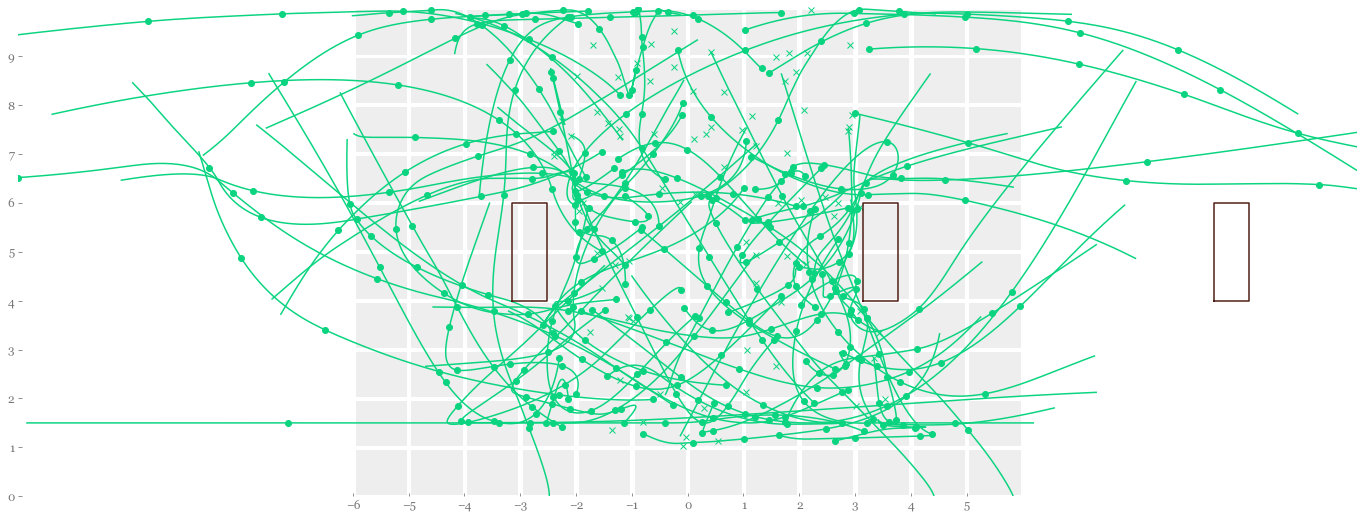

In [27]:
# Vary by randomizing start and end states

import ilqr
import csv
import level_sets

# Initialize the dynamics
safeLevel = level_sets.GriddedLevelSetFunction("reachsets/telescopingVInvertedPendulum5TenthsNoMidLength_LengthBounds_reachset.json")
vehicle = TelescopingInvertedPendulum()
safe_vehicle = dyn.MinimumInterventionDynamicsWrapper(vehicle,safeLevel)
#safe_vehicle = vehicle
timestep_length = 0.01

# Initialize the traces' memory objects
N = 500
states_init = np.zeros((safe_vehicle.dimZ,N+1))
control_init = np.zeros((safe_vehicle.dimU,N))

# Setup the figure
fig = plt.figure(figsize=[24,9])
plt.axis([-12,12,0,10])
ax = fig.axes[0]
muteAxes(ax,range(-6,6),range(0,10))

dotTimes = np.arange(0,N,100)

OptimizedTraces = []
optimized_states = [[np.zeros((safe_vehicle.dimZ,N+1)) for jj in range(3)] for ii in range(100)]
optimized_controls = [[np.zeros((safe_vehicle.dimU,N)) for jj in range(3)] for ii in range(100)]
optimized_cost = [[0 for jj in range(3)] for ii in range(100)]

# Repeat optimization for multiple starting states
for ii in range(20,100):
    # Repeat for three runs
    lowest_jj = 0
    for jj in range(3):
        # Proscribe the terminal cost from the random goal state
        Qprox = np.diag([1,0,1,0])
        goal_state = np.copy(endingGoals[ii])
        #goal_state[1] = 0
        terminalCost = of.TerminalCost(
            WrappedFirstState(
                qof.QuadraticStateCost(
                dlqr.QuadraticForm(vehicle.dimZ,Qprox,
                                   -2*Qprox*np.matrix(goal_state).T,
                                   np.dot(np.dot(goal_state.transpose(),Qprox),goal_state) )
                )
            , 2*np.pi, goal_state[0]-np.pi)
            * 80)
        
        # Initialize a random control-trace
        cost = 999999
        while cost > 10000:
            # Forward simulate the dynamics with zero control
            startingState = np.copy(startingStates[ii])
            states_init[:,0] = startingState
            cost = 0
            #control_init[:,-1] = np.zeros((safe_vehicle.dimU,))
            constant_control = np.random.rand(safe_vehicle.dimU,)*2 - np.ones((safe_vehicle.dimU,))
            for i in np.arange(0,N):
                #control_init[:,i] = control_init[:,i-1] + timestep_length*(np.random.rand(safe_vehicle.dimU,)*2 - np.ones((safe_vehicle.dimU,)))
                control_init[:,i] = constant_control
                states_init[:,i+1] = states_init[:,i] + timestep_length * safe_vehicle.f(states_init[:,i],control_init[:,i])
                cost = cost + timestep_length*Agent_objective.f(states_init[:,i],control_init[:,i],i)
            cost = cost + terminalCost.f(states_init[:,N])
            print("Initial cost is ",cost)
        
        # Optimize the trajectory
        mintervener_method_states, mintervener_method_controls = ilqr.iterative_LQR(states_init,control_init,
                                                                                    timestep_length,
                                                                                    safe_vehicle,
                                                                                    Agent_objective,
                                                                                    terminal_cost = terminalCost * (1/timestep_length),
                                                                                    neverRetreat=True,ITER_NUM=8)
        # Save the result
        optimized_states[ii][jj] = mintervener_method_states
        optimized_controls[ii][jj] = mintervener_method_controls
        # Assess the result
        optimized_cost[ii][jj] = 0
        for i in np.arange(0,N):
            optimized_cost[ii][jj] = optimized_cost[ii][jj] + timestep_length*Agent_objective.f(mintervener_method_states[:,i],mintervener_method_controls[:,i],i)
        optimized_cost[ii][jj] = optimized_cost[ii][jj] + terminalCost.f(mintervener_method_states[:,N])
        # Find if this result is the current winner for this start-goal ii
        if optimized_cost[ii][jj] < optimized_cost[ii][lowest_jj]:
            lowest_jj = jj
    
    # Pull out the most optimal from that batch to visualize and export
    mintervener_method_states = optimized_states[ii][lowest_jj]
    mintervener_method_controls = optimized_controls[ii][lowest_jj]
    print("Lowest cost from the batch on this start-goal-pair is ===== ", optimized_cost[ii][lowest_jj])
    
    # Plot the iterative LQR optimized trajectory
    #thiscolor = colors[0][ii%9]
    thiscolor = colors[2][1]
    plt.plot(mintervener_method_states[0,:],mintervener_method_states[2,:],color=thiscolor)
    plt.plot(mintervener_method_states[0,dotTimes],
             mintervener_method_states[2,dotTimes],
             'ro',color=thiscolor)
    plt.plot(goal_state[0],
             goal_state[2],'x',color=thiscolor)
    OptimizedTraces.append(mintervener_method_states)

    # Export
    aug_controls0 = np.append(mintervener_method_controls[0,:],[0])
    aug_controls1 = np.append(mintervener_method_controls[1,:],[0])
    with open('export/telescopingPendulumAgent_NoMidLengthAtPi'+str(ii)+'.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(mintervener_method_states[0,:])
        writer.writerow(mintervener_method_states[1,:])
        writer.writerow(mintervener_method_states[2,:])
        writer.writerow(mintervener_method_states[3,:])
        writer.writerow(aug_controls0)
        writer.writerow(aug_controls1)
        
# Plot the constraint
obsAngTick = 5
angle1 = ( obsAngTick   /10)*2*np.pi
angle2 = ((obsAngTick+1)/10)*2*np.pi
#ys = np.array([-10,-10, 10, 10,-10])
#ys = ys * 0.12
#ys = ys * 0.06 + 0.6
ys = np.array([4,4,6,6,4])
plt.plot(np.array([angle1,angle2,angle2,angle1,angle1]),
         np.array(ys),
         color=colors[1][0])
plt.plot(np.array([angle1-2*np.pi,angle2-2*np.pi,angle2-2*np.pi,angle1-2*np.pi,angle1-2*np.pi]),
         np.array(ys),
         color=colors[1][0])
plt.plot(np.array([angle1+2*np.pi,angle2+2*np.pi,angle2+2*np.pi,angle1+2*np.pi,angle1+2*np.pi]),
         np.array(ys),
         color=colors[1][0])

plt.show
plt.savefig("TIP_NoMidLengthAtPiTaxi_triplicated.pdf")
# 0:Rust, 1:Turquoise, 2:Sand, 3:Indigo, 4:Teal, 5:Spring, 6:Flesh, 7:Magenta, 8:Gray

In [28]:
filename = 'export/telescopingPendulumAgent_startEnds_NoMidLengthAtPiTaxi_triplicated'
with open(filename+'.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(range(0,100))
    writer.writerow([start[0] for start in startingStates])
    writer.writerow([start[1] for start in startingStates])
    writer.writerow([start[2] for start in startingStates])
    writer.writerow([start[3] for start in startingStates])
    writer.writerow([goal[0] for goal in endingGoals])
    writer.writerow([goal[1] for goal in endingGoals])
    writer.writerow([goal[2] for goal in endingGoals])
    writer.writerow([goal[3] for goal in endingGoals])

In [30]:
import json

optimized_states_listy = [[trajectory.tolist() for trajectory in batch] for batch in optimized_states]
optimized_controls_listy = [[trajectory.tolist() for trajectory in batch] for batch in optimized_controls]
optimized_costs_listy = [[trajectory.tolist() for trajectory in batch] for batch in optimized_cost]

with open(filename+'.json', 'w') as filehandle:
    json.dump({'states': optimized_states_listy,
               'controls': optimized_controls_listy,
               'costs': optimized_costs_listy
              },
              filehandle, sort_keys=True, indent=4)

# Vary by control-sequence initialization

Initial cost is  [[178.85080649]]
Initialization's cost is  178.85080648570275
1 168.66979543671363
2 4.3653591265399045
3 0.6200990589783952
Initial cost is  [[13117.51483836]]
Initial cost is  [[199898.97713031]]
Initial cost is  [[2818.89968407]]
Initialization's cost is  2818.899684067443
1 1854.725541333636
2 1520.9435772068844
3 1402.7774722775168
Initial cost is  [[137198.24169811]]
Initial cost is  [[949.76754248]]
Initialization's cost is  949.7675424817851
1 919.029291995899
2 4.394955064838825
3 0.07144831808054786
Initial cost is  [[44853.67513755]]
Initial cost is  [[210617.95532603]]
Initial cost is  [[17215.96349563]]
Initial cost is  [[145851.96232216]]
Initial cost is  [[129344.87404193]]
Initial cost is  [[196.66697549]]
Initialization's cost is  196.66697548805905
1 5.7771076406596915
2 2.8088501597613025
3 2.643461247876948
Initial cost is  [[170499.11064434]]
Initial cost is  [[2651.39925493]]
Initialization's cost is  2651.3992549336654
1 1574.7943717955945
2 1164

1 2325.1524148611666
2 17.135789166075654
3 0.22402898308001867
Initial cost is  [[15462.26564355]]
Initial cost is  [[167850.32404338]]
Initial cost is  [[48229.6222891]]
Initial cost is  [[48912.84946671]]
Initial cost is  [[268422.49291195]]
Initial cost is  [[2689.55662444]]
Initialization's cost is  2689.5566244440797
1 2213.5257954214003
2 2064.1302865960183
3 1820.7652604729774
Initial cost is  [[153030.34520892]]
Initial cost is  [[234824.62650311]]
Initial cost is  [[81.22397506]]
Initialization's cost is  81.2239750612861
1 19.57303438283857
2 4.638384697791101
3 0.2012543306763592
Initial cost is  [[203794.64724085]]
Initial cost is  [[1839.99090733]]
Initialization's cost is  1839.990907332603
1 1185.681295002329
2 659.7082021386686
3 18.882252632813948
Initial cost is  [[2859.77360046]]
Initialization's cost is  2859.773600459722
1 2111.058044666603
2 1982.8139657104482
3 1727.1745263280734
Initial cost is  [[72021.93169853]]
Initial cost is  [[149317.75402288]]
Initial co

3 1.9800930807826742
Initial cost is  [[2821.38484764]]
Initialization's cost is  2821.384847638601
1 1907.4383918398858
2 1612.7925340185361
3 1457.8016357429467
Initial cost is  [[2826.58337411]]
Initialization's cost is  2826.5833741107367
1 2376.28880996172
2 27.753492383532482
3 0.3937154433583191
Initial cost is  [[80.95841824]]
Initialization's cost is  80.95841824186276
1 46.63046163356952
2 0.5586823583231924
3 0.0431368169308404
Initial cost is  [[78.12349402]]
Initialization's cost is  78.12349401784992
1 18.436099177010803
2 4.162989977557695
3 0.9372098026783079
Initial cost is  [[218.45289952]]
Initialization's cost is  218.45289952356816
1 64.45693505326857
2 8.051048370980627
3 0.189159228923249
Initial cost is  [[69.45848247]]
Initialization's cost is  69.4584824728983
1 13.295790865084784
2 2.6334278203029426
3 1.6751725493573777
Initial cost is  [[177.79384331]]
Initialization's cost is  177.79384330904995
1 71.56857676544502
2 5.7630400827620125
3 5.43996474206013
I

<function matplotlib.pyplot.show(close=None, block=None)>

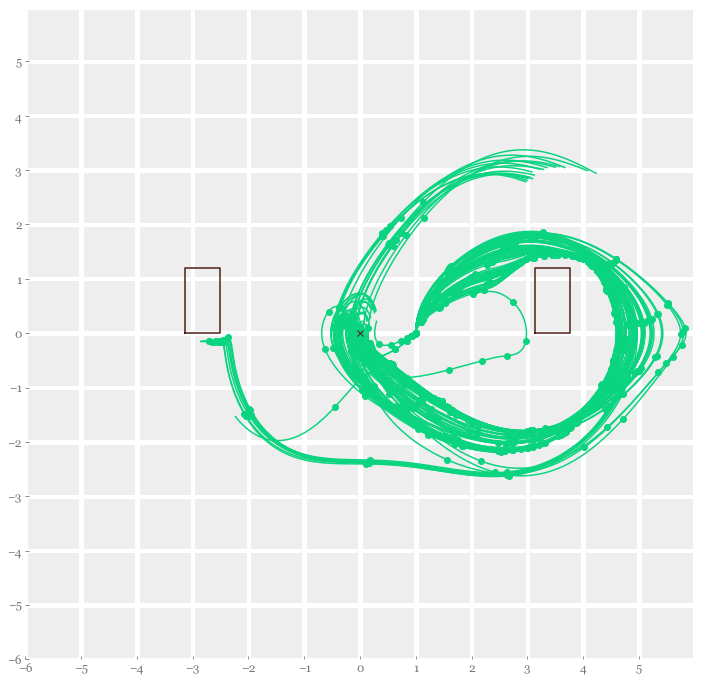

In [21]:
# Vary by randomizing initial control sequence

import ilqr
import csv
import level_sets

# Initialize the dynamics
safeLevel = level_sets.GriddedLevelSetFunction("reachsets/invertedPendulum5TenthsNopeV_reachset.json")
vehicle = InvertedPendulum()
safe_vehicle = dyn.MinimumInterventionDynamicsWrapper(vehicle,safeLevel)
timestep_length = 0.01

# Initialize the traces' memory objects
N = 1000
startingState = [1,0]
states_init = np.zeros((safe_vehicle.dimZ,N+1))
control_init = np.zeros((safe_vehicle.dimU,N))

# Initialize the figure
fig = plt.figure(figsize=[12,12])
plt.axis([-6,6,-6,6])
ax = fig.axes[0]
muteAxes(ax,range(-6,6),range(-6,6))

dotTimes = np.arange(0,N,100)

# Repeat optimization for multiple starting states
for ii in range(1,100):
    cost = 999999
    while cost > 10000:
        # Forward simulate the dynamics with zero control
        states_init[:,0] = startingState
        cost = 0
        #control_init[:,-1] = np.zeros((safe_vehicle.dimU,))
        constant_control = np.random.rand(safe_vehicle.dimU,)*2 - np.ones((safe_vehicle.dimU,))
        for i in np.arange(0,N):
            #control_init[:,i] = control_init[:,i-1] + timestep_length*(np.random.rand(safe_vehicle.dimU,)*2 - np.ones((safe_vehicle.dimU,)))
            control_init[:,i] = constant_control
            states_init[:,i+1] = states_init[:,i] + timestep_length * safe_vehicle.f(states_init[:,i],control_init[:,i])
            cost = cost + timestep_length*Agent_objective.f(states_init[:,i],control_init[:,i],i)
        cost = cost + terminalCost.f(states_init[:,N])
        print("Initial cost is ",cost)
        
    # Optimize the trajectory
    mintervener_method_states, mintervener_method_controls = ilqr.iterative_LQR(states_init,control_init,
                                                                                timestep_length,
                                                                                safe_vehicle,
                                                                                Agent_objective,
                                                                                terminal_cost = terminalCost * (1/timestep_length),
                                                                                neverRetreat=True,ITER_NUM=4)
    
    # Plot the iterative LQR optimized trajectory
    plt.plot(mintervener_method_states[0,:],mintervener_method_states[1,:],color=colors[2][1])
    plt.plot(mintervener_method_states[0,dotTimes],
             mintervener_method_states[1,dotTimes],
             'ro',color=colors[2][1])

    # Export
    aug_controls = np.append(mintervener_method_controls[0,:],[0])
    with open('export/pendulumAgent_5TenthsNopeVObstacleTruncated'+str(ii)+'.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(mintervener_method_states[0,:])
        writer.writerow(mintervener_method_states[1,:])
        writer.writerow(aug_controls)
        
# Plot the goal point
plt.plot(goal_state[0],goal_state[1],'x',color=colors[1][0])
# Plot the constraint
obsAngTick = 5
angle1 = ( obsAngTick   /10)*2*np.pi
angle2 = ((obsAngTick+1)/10)*2*np.pi
ys = np.array([-10,-10, 10, 10,-10])
#ys = ys * 0.12
ys = ys * 0.06 + 0.6
plt.plot(np.array([angle1,angle2,angle2,angle1,angle1]),
         np.array(ys),
         color=colors[1][0])
plt.plot(np.array([angle1-2*np.pi,angle2-2*np.pi,angle2-2*np.pi,angle1-2*np.pi,angle1-2*np.pi]),
         np.array(ys),
         color=colors[1][0])

plt.show